In [142]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [143]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [144]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [145]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [146]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [147]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [148]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [149]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [150]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [151]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
df = [Measurement.date,Measurement.prcp]
precipitation_data = session.query(*df).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data = pd.DataFrame(precipitation_data,columns=['Date','Precipitation'])

# Sort the dataframe by date
precipitation_data = precipitation_data.sort_values(by = 'Date')
precipitation_data.head()

,Date,Precipitation
0,2016-08-24,2.0
1006,2016-08-24,NaN
1524,2016-08-24,54.6
702,2016-08-24,57.9
360,2016-08-24,54.6


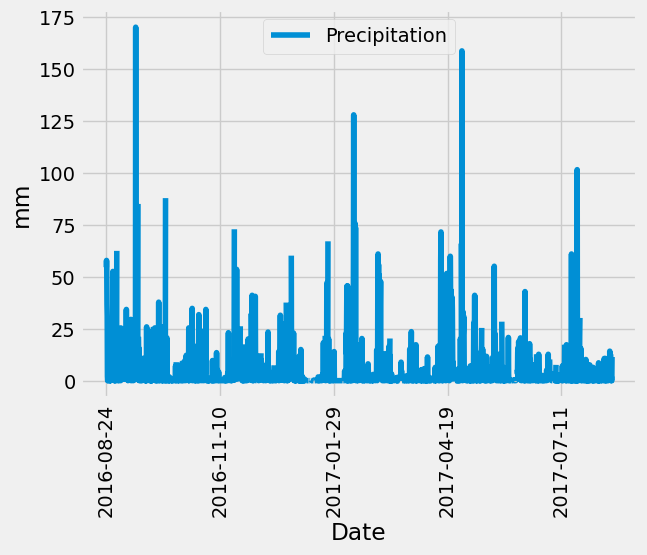

In [152]:
precipitation_data.set_index("Date", inplace=True)
precipitation_data.plot(rot = 90)
plt.ylabel("mm")
plt.xlabel("Date")
plt.show()
plt.show()

In [153]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_data.describe()

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [154]:
# Design a query to calculate the total number of stations in the dataset
num_station = session.query(Station.station).count()
print(num_station)

9


In [155]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = [Measurement.station,func.count(Measurement.id)]
activestations = session.query(*active_stations).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [156]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

data = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostactivestationdata = session.query(*data).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
mostactivestationdata

(12.2, 29.4, 22.03582251082252)

USC00519281


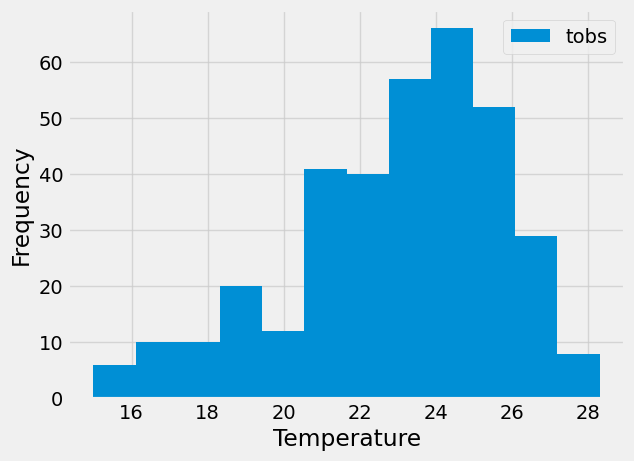

In [157]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
print(activestations[0][0])

queryresult = session.query(Measurement.tobs).filter(Measurement.station == activestations[0][0]).filter(Measurement.date >= one_year_ago).all()
temperatures = list(np.ravel(queryresult))

col = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*col).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == activestations[0][0],"Name"].tolist()[0]
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend()

# Close Session

In [158]:
# Close Session
session.close()